<a href="https://colab.research.google.com/github/yaswanthkarri2004/Maleria_detection_using_Yolo-CvT/blob/main/yolo%2Bcvt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install torch torchvision transformers ultralytics opencv-python pillow


In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17410, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 17410 (delta 63), reused 22 (delta 22), pack-reused 17320 (from 3)
Receiving objects: 100% (17410/17410), 16.29 MiB | 11.42 MiB/s, done.
Resolving deltas: 100% (11926/11926), done.
/content/yolov5/yolov5


YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
/usr/local/lib/python3.11/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


📂 Upload an image file:


Saving C113P74ThinF_IMG_20150930_134949_cell_129.png to C113P74ThinF_IMG_20150930_134949_cell_129.png
✅ Image uploaded: C113P74ThinF_IMG_20150930_134949_cell_129.png

🔹 Input Image:


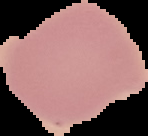


🔹 YOLO Processed Image (Restored to Normal Size):


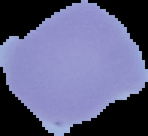

-24.85955810546875 -14.43035888671875 652.3265380859375 650.6141967773438 0.6201906800270081 1.0 rfgdf
✅ Detected: Uninfected (1.00)

🔹 Final Detection:


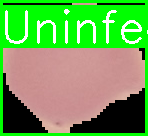

In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from transformers import AutoFeatureExtractor, CvtForImageClassification
from yolov5.models.common import DetectMultiBackend
from yolov5.utils.general import non_max_suppression
from yolov5.utils.torch_utils import select_device
from google.colab import files

# ✅ Check if running in Google Colab
try:
    from google.colab.patches import cv2_imshow
    colab_mode = True
except ImportError:
    colab_mode = False

# **1️⃣ Load YOLOv5 Model**
device = select_device('cuda' if torch.cuda.is_available() else 'cpu')
yolo_model = DetectMultiBackend("/content/drive/MyDrive/YOLO_Project/exp4/weights/best.pt", device=device)
yolo_model.eval()

# **2️⃣ Load CvT Model**
cvt_model_name = "microsoft/cvt-13"
feature_extractor = AutoFeatureExtractor.from_pretrained(cvt_model_name)
cvt_model = CvtForImageClassification.from_pretrained(cvt_model_name, ignore_mismatched_sizes=True)
cvt_model.classifier = torch.nn.Linear(cvt_model.classifier.in_features, 2)
cvt_model.load_state_dict(torch.load("/content/drive/MyDrive/CVT/cvt_model2.pth", map_location=device))
cvt_model.to(device)
cvt_model.eval()

# **Define Class Labels**
class_labels = ["Parasitized", "Uninfected"]

# **Define Transform for CvT Model**
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# ✅ Function to Select Image from File Dialog
def select_image():
    print("📂 Upload an image file:")
    uploaded = files.upload()  # Opens file uploader in Colab

    if uploaded:
        file_path = list(uploaded.keys())[0]  # Get the uploaded file name
        print(f"✅ Image uploaded: {file_path}")
        return file_path
    return None

# **Function to Process Image and Get Predictions**
def detect_and_classify(image_path, output_path="output.jpg"):
    # **Load Image**
    image = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]  # (Height, Width)

    # ✅ Show Input Image
    print("\n🔹 Input Image:")
    if colab_mode:
        cv2_imshow(image)
    else:
        cv2.imshow("Input Image", image)
        cv2.waitKey(0)

    # **Resize for YOLO and then Restore to Original Size**
    img_resized = cv2.resize(img_rgb, (640, 640))
    img_resized_back = cv2.resize(img_resized, (original_size[1], original_size[0]))  # Resize back to original

    print("\n🔹 YOLO Processed Image (Restored to Normal Size):")
    if colab_mode:
        cv2_imshow(img_resized_back)
    else:
        cv2.imshow("YOLO Processed Image", img_resized_back)
        cv2.waitKey(0)

    # **Prepare Image for YOLO**
    img_tensor = transforms.ToTensor()(Image.fromarray(img_resized)).unsqueeze(0).to(device).float()

    with torch.no_grad():
        pred = yolo_model(img_tensor)[0]

    detections = non_max_suppression(pred, 0.4, 0.5)[0]

    if detections is None or len(detections) == 0:
        print("No objects detected!")
        return

    original_image = image.copy()
    img_height, img_width = original_image.shape[:2]  # Get image dimensions

    for det in detections:
        x1, y1, x2, y2, conf, cls = det.tolist()
        print(x1, y1, x2, y2, conf, cls,"rfgdf")
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

        # **Ensure Bounding Box is Within Image Bounds**
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img_width - 1, x2), min(img_height - 1, y2)

        # **Crop detected region**
        cropped = img_rgb[y1:y2, x1:x2]

        # ✅ Handle empty crops
        if cropped.shape[0] == 0 or cropped.shape[1] == 0:
            print("Warning: Skipping empty cropped region.")
            continue

        cropped_pil = Image.fromarray(cropped)

        # **Transform and classify with CvT**
        input_tensor = transform(cropped_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = cvt_model(input_tensor).logits
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = torch.softmax(outputs, dim=1)[0, predicted_class].item()

        # **Get Label**
        label = f"{class_labels[predicted_class]} ({confidence:.2f})"
        print(f"✅ Detected: {label}")  # Debugging output

        # **Draw Bounding Box and Label on Image**
        color = (0, 255, 0) if predicted_class == 1 else (0, 0, 255)  # Green = Uninfected, Red = Parasitized
        cv2.rectangle(original_image, (x1, y1), (x2, y2), color, 3)

        # ✅ **Fix Text Overlapping / Visibility**
        font_scale = max(0.5, min(2, (x2 - x1) / 100))  # Scale text size dynamically
        thickness = 2  # Increase thickness
        text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

        # **Ensure Label Stays Inside the Image**
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > text_size[1] else y1 + text_size[1] + 10  # Place inside box if needed

        # ✅ Draw Background for Text
        cv2.rectangle(original_image, (text_x, text_y - text_size[1] - 5),
                      (text_x + text_size[0] + 5, text_y + 5), color, -1)

        # ✅ Overlay Text Label
        cv2.putText(original_image, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    # **Save and Show Final Image**
    cv2.imwrite(output_path, original_image)

    print("\n🔹 Final Detection:")
    if colab_mode:
        cv2_imshow(original_image)
    else:
        cv2.imshow("Final Detection", original_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# **Main Function**
def main():
    img_path = select_image()

    if img_path:
        detect_and_classify(img_path, "output.jpg")

# **Run Main Function**
main()


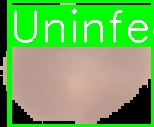

In [ ]:
from IPython.display import display
from PIL import Image

final_image = Image.open("output.jpg")
display(final_image)


In [ ]:
## Accuracy
import torch
import cv2
import os
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from transformers import AutoFeatureExtractor, CvtForImageClassification
from yolov5.models.common import DetectMultiBackend
from yolov5.utils.general import non_max_suppression
from yolov5.utils.torch_utils import select_device
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm  # For progress bar

# ✅ Load YOLOv5 Model
device = select_device('cuda' if torch.cuda.is_available() else 'cpu')
yolo_model = DetectMultiBackend("/content/drive/MyDrive/YOLO_Project/exp5/weights/best.pt", device=device)
yolo_model.eval()

# ✅ Load CvT Model
cvt_model_name = "microsoft/cvt-13"
feature_extractor = AutoFeatureExtractor.from_pretrained(cvt_model_name)
cvt_model = CvtForImageClassification.from_pretrained(cvt_model_name, ignore_mismatched_sizes=True)
cvt_model.classifier = torch.nn.Linear(cvt_model.classifier.in_features, 2)
cvt_model.load_state_dict(torch.load("/content/drive/MyDrive/CVT/cvt_model3.pth", map_location=device))
cvt_model.to(device)
cvt_model.eval()

# ✅ Define Class Labels
class_labels = ["Parasitized", "Uninfected"]

# ✅ Define Transform for CvT Model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# ✅ Function to Process Images and Get Predictions
def classify_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Could not load {image_path}")
        return None

    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (640, 640))
    img_tensor = transforms.ToTensor()(Image.fromarray(img_resized)).unsqueeze(0).to(device).float()

    # **Run YOLOv5**
    with torch.no_grad():
        pred = yolo_model(img_tensor)[0]

    detections = non_max_suppression(pred, 0.4, 0.5)[0]

    if detections is None or len(detections) == 0:
        print(f"⚠️ No objects detected in {image_path}")
        return None

    predictions = []
    for det in detections:
        x1, y1, x2, y2, conf, cls = map(int, det.tolist()[:6])

        # Ensure bounding box is within image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image.shape[1], x2), min(image.shape[0], y2)

        cropped = img_rgb[y1:y2, x1:x2]
        if cropped.size == 0:
            continue

        cropped_pil = Image.fromarray(cropped)
        input_tensor = transform(cropped_pil).unsqueeze(0).to(device)

        # **Run CvT Model**
        with torch.no_grad():
            outputs = cvt_model(input_tensor).logits
            predicted_class = torch.argmax(outputs, dim=1).item()

        predictions.append(predicted_class)

    return predictions

# ✅ Function to Evaluate Model on Test Dataset
def evaluate_model(test_dir):
    y_true = []
    y_pred = []

    for label, class_dir in enumerate(["Parasitized", "Uninfected"]):
        class_path = os.path.join(test_dir, class_dir)
        if not os.path.exists(class_path):
            print(f"⚠️ Warning: Directory {class_path} not found!")
            continue

        print(f"🔍 Processing {class_dir} images...")
        for img_file in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_file)

            predictions = classify_image(img_path)
            if predictions is not None:
                y_true.extend([label] * len(predictions))
                y_pred.extend(predictions)

    # ✅ Compute Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n✅ Model Accuracy: {accuracy:.4f}")

    # ✅ Print Classification Report
    print("\n🔹 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

# ✅ Run Model Evaluation on Test Data
test_data_path = "/content/drive/MyDrive/YOLO_project/dataset/yolo_subset/images/val"
evaluate_model(test_data_path)


YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
/usr/local/lib/python3.11/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


🔍 Processing Parasitized images...


 46%|████▌     | 91/200 [01:19<01:06,  1.64it/s]

⚠️ No objects detected in /content/drive/MyDrive/YOLO_project/dataset/yolo_subset/images/val/Parasitized/C103P64ThinF_IMG_20150918_165125_cell_166.png


 70%|███████   | 140/200 [01:57<00:36,  1.63it/s]

⚠️ No objects detected in /content/drive/MyDrive/YOLO_project/dataset/yolo_subset/images/val/Parasitized/C113P74ThinF_IMG_20150930_134949_cell_161.png


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


🔍 Processing Uninfected images...


  6%|▋         | 13/200 [00:10<01:56,  1.60it/s]

⚠️ No objects detected in /content/drive/MyDrive/YOLO_project/dataset/yolo_subset/images/val/Uninfected/C100P61ThinF_IMG_20150918_150041_cell_108.png


100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


✅ Model Accuracy: 0.9370

🔹 Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.96      0.92      0.94       212
  Uninfected       0.92      0.96      0.94       201

    accuracy                           0.94       413
   macro avg       0.94      0.94      0.94       413
weighted avg       0.94      0.94      0.94       413



1. Yolo : exp4, CVT : 1, Accuracy : 84.9%
2. Yolo : exp5, CVT : 3, Accuracy : 93.7%
3. Yolo : exp5, CVT : 2, Accuracy : 86.4%
3. Yolo : exp6, CVT : 4, Accuracy : 91%
4. Yolo : exp5, CVT : 4, Accuracy : 91.5%
5. Yolo : exp4, CVT : 2, Accuracy : 94.39%